# Divansh Prasad (210968140) Week-5 AI Lab

## Exercises
a. Write down the “Movie Recommendation” as a Reinforcement Learning problem
formulation. Use comment lines for proper documentation. \
b. For the environment, use the built-in TF-agent agent, MovieLensPyEnvironment (non-
per-arm) 
https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environment
s/movielens_py_environment.py  \
c. Compute the regret using the built-in metric in TF-agents
https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_m
etrics.py \
d. Plot the regret against 20,000-time steps using the built-in agents:
1. LinUCB 
2. LinTS 
3. NeuralEpsilonGreedy\
And identify the best agent for the movie recommendation.

e. Write the Recommendation policy, given a new observation request (i.e. a user vector),
the policy will produce actions, which are the recommended movies

### a. Write down the MAB agent problem formulation in your own words.

An advertising agency has 10 different ads. They want to find the ad which will get the most clicks by users, and is this most profitable. We need to help the agency in finding the most suited add to maximize the conversions through them.

In [1]:
import tensorflow as tf
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
from matplotlib import pyplot as plt

2024-02-21 23:30:43.529124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 23:30:43.554648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 23:30:43.554690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 23:30:43.555585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 23:30:43.560063: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 23:30:43.561095: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
BATCH_SIZE = 8
TRAINING_LOOPS = 200 #20000 takes a lot of time
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

data_path = '/home/divansh/ml-100k/u.data'

### b. For the environment, use the built-in TF-agent agent, MovieLensPyEnvironment (non-per-arm) 

In [3]:
env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

### c. Compute the regret using the built-in metric in TF-agents

In [4]:
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)


optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

In [5]:
AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

2024-02-21 23:30:45.726959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 23:30:45.727539: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

In [7]:
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])


In [8]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

In [9]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

### d. Plot the regret against 20,000-time steps using the built-in agents:

### 1. LinUCB 


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0, 0.5, 'Average Regret')

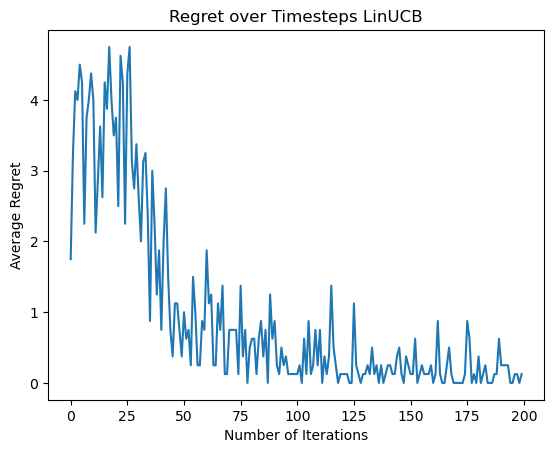

In [10]:
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')


In [11]:
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=194.125>

### 2. LinTS 


Text(0, 0.5, 'Average Regret')

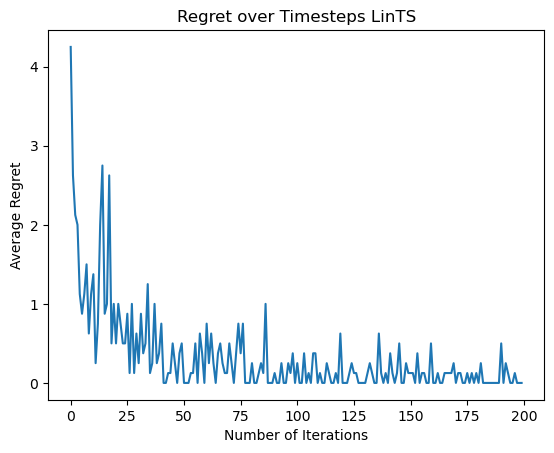

In [12]:
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [13]:
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=65.625>

### 3. NeuralEpsilonGreedy

Text(0, 0.5, 'Average Regret')

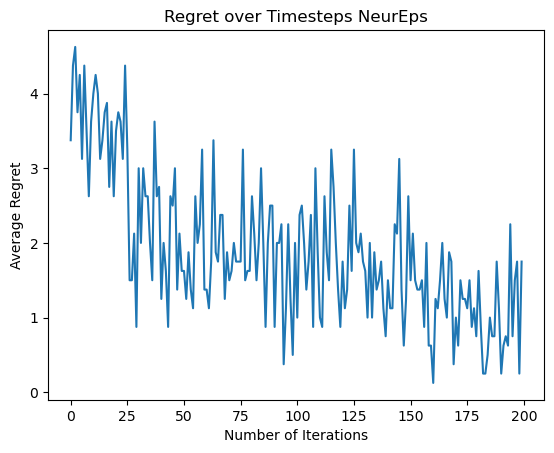

In [14]:
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [15]:
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=381.25>

### Identify the best agent for the movie recommendation
LinTS is the best agent as regret dropped to near zero faster than LinUCB. Epsilon Greedy seems to have some regret value even after 20000 iterations.

### e. Write the Recommendation policy, given a new observation request (i.e. a user vector),the policy will produce actions, which are the recommended movies

In [16]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)

    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [17]:
# Generate random observation
observation_shape = (1, 20) 
random_observation = np.random.randint(2, size=observation_shape)

# Call the recommend_movies function with the random observation
recommend_movies(lints_agent, observation=random_observation)

9